# Tutorial: How to run erro mitigated state reconstruction.

## Import files and libraries

In [2]:
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product
from joblib import Parallel, delayed
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from functools import reduce
from cvxopt import matrix, solvers

## Computational basis error mitigation

Not Physical, correcting marginal
     pcost       dcost       gap    pres   dres
 0: -4.5643e-01 -1.5549e+00  1e+00  0e+00  3e+00
 1: -4.7588e-01 -5.3359e-01  6e-02  1e-16  1e-01
 2: -4.9402e-01 -5.0122e-01  7e-03  1e-16  2e-03
 3: -4.9687e-01 -4.9785e-01  1e-03  6e-17  6e-17
 4: -4.9727e-01 -4.9739e-01  1e-04  1e-16  8e-17
 5: -4.9735e-01 -4.9736e-01  1e-05  1e-16  3e-17
 6: -4.9735e-01 -4.9735e-01  2e-07  2e-16  8e-17
Optimal solution found.
Measured marginal :
[0.022 0.026 0.003 0.002 0.435 0.415 0.042 0.055]
Inital corrected marginal :
[-0.00454789  0.00802312  0.00203818 -0.00275845  0.52092592  0.47505155
 -0.01346322  0.01981367]
Physical marginal :
[5.53152026e-07 2.08122419e-03 1.24830279e-05 9.54580355e-07
 5.14963741e-01 4.69089371e-01 1.11730642e-07 1.38515612e-02]
True marginal :
[0.  0.  0.  0.  0.5 0.5 0.  0. ]
Distance between physical and true marginal : 0.037088783982580975


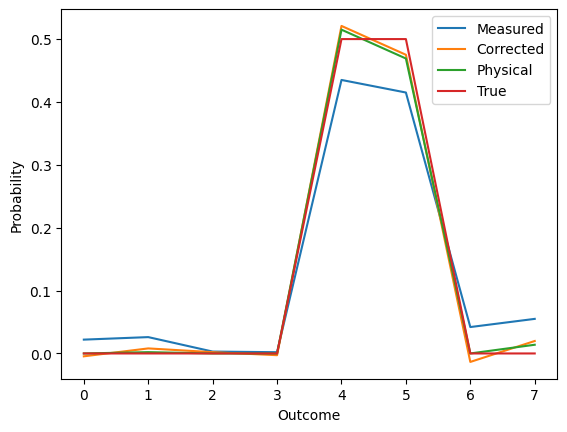

In [553]:
import numpy as np
#np.random.seed(0)
# To define some nessecary functions. 
# To check that probability marginal is physical
def is_margianl_physical(marginal):
    # Checks if marginal probability vector is physical. Checks if all elements are positive and if the sum is 1.
    return np.all(marginal>=0) and np.isclose(np.sum(marginal),1,atol=1e-5)

# Measurements only needs to be in the form of frequencies, i.e. n_i/N.
def probability_marginal_measurements(n_shots, povm, rho):
    return_frequencies = True
    marginal = mf.simulated_measurement(n_shots,povm,rho,return_frequencies)/n_shots
    # Put whatever else you want here....
    #print(rho)
    # Return should be on the form p = [n_0/N, n_1/N, ... , n_{2^n_qubits-1}/N]
    return marginal

def plot_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
def plot_distributions(distributions,names):
    """
    Plots a list of probability distributions.
    
    Parameters:
    - distributions (list): A list of probability distributions. Each distribution should be a list or numpy array of probabilities.
    
    Returns:
    - None
    """
    for i, distribution in enumerate(distributions):
        plt.plot(distribution, label=f"{names[i]}")
    
    plt.xlabel("Outcome")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


# Define nessecary parameters
n_qubits = 3
mode = "Comp"
n_QDT_shots = 10**4
n_observable_shots = 10**3
exp_dict = {}
pauli_states = sf.get_calibration_states(n_qubits,mode)[0]
comp_POVM = POVM.computational_basis_POVM(n_qubits)[0]
pauli_angles = comp_POVM.get_angles()
#print(pauli_angles)
# Measurement angles and comp basis and probability marginals
# follow the order [000, 001, 010, 011, ... , 111]	


# For numerical testing, create the noisy POVM
noise1 = POVM.depolarized_POVM(POVM.computational_basis_POVM(1)[0],0.2)
noise2 = POVM.depolarized_POVM(POVM.computational_basis_POVM(1)[0],0.1)
noise3 = POVM.depolarized_POVM(POVM.computational_basis_POVM(1)[0],0.5)
composite_noise = POVM.tensor_POVM(POVM.tensor_POVM(np.array([noise2]), np.array([noise1])),np.array([noise3]))
noise_comp = POVM.depolarized_POVM(POVM.computational_basis_POVM(n_qubits)[0],0.1)

# Define the state you want to measure (IDK how you specify the system you want to measure)
rho1 = np.array([[1,1],[1,1]])*1/2  
rho2 = np.array([[1,0],[0,0]])
rho3 = np.array([[0,0],[0,1]])
rho_sample = np.kron(np.kron(rho3,rho2),rho1)
#rho_sample = sf.generate_random_pure_state(n_qubits)

# Calibrate the confusion matrix, makes 8 calls for the 8 pauli states
C_meaured = np.array([probability_marginal_measurements(n_QDT_shots, composite_noise[0], rho) for rho in pauli_states])

# Measure the probability marginal of intrest
exp_marginal = probability_marginal_measurements(n_observable_shots, composite_noise[0], rho_sample)

# Compute the inverted confusion matrix and initial corrected marginal
C_measured_inv = np.linalg.inv(C_meaured)
# plot_matrix(C_meaured)
# plot_matrix(C_measured_inv)
#plot_matrix(np.dot(C_measured_inv,C_meaured))
corrected_marginal = np.real(np.einsum('ij,j->i',C_measured_inv, exp_marginal))

# For numerics
comp_POVM = comp_POVM.get_POVM()
true_marginal = np.real(np.einsum('ijk,kj->i',comp_POVM,rho_sample))


# Check if it needs to be further corrected, e.g. for real entries
if is_margianl_physical(corrected_marginal):
    print("Physical")
    physical_marginal = corrected_marginal
    
else: 
    n = 2**n_qubits
    print("Not Physical, correcting marginal")
    # Define solver parameters (using cvxopt)
    P = 2*matrix(np.eye(n))
    q = matrix(-2*corrected_marginal)
    G = matrix(0.0, (n,n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n,1))
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    sol = solvers.qp(P,q,G,h,A,b)
    #print(sol['x'])
    #print(np.array(sol['x']))
    physical_marginal = np.array(sol['x']).flatten()
print(f'Measured marginal :\n{exp_marginal}')
print(f'Inital corrected marginal :\n{corrected_marginal}')    
print(f'Physical marginal :\n{physical_marginal}')
#print(np.sum(physical_marginal))
print(f'True marginal :\n{true_marginal}')
print(f'Distance between physical and true marginal : {np.linalg.norm(physical_marginal-true_marginal)}')

plot_distributions([exp_marginal, corrected_marginal, physical_marginal, true_marginal],names=["Measured","Corrected","Physical","True"])


## Example of how to run REM overlapping tomography
For this we require a perfect family of hashing functions, denoted by $(N,k,m,m)$, where $N$ is the total number of hashing fuctions, $k$ is the size of the total system and m is the size of the subsystem you want to reconstruct arbitrary correlators. The number of hashing functions scales exponentially in $k$, but logarithmically in $m$.


A more user friendly order of operation is
1. Front-load all measurements
    1. Create/load the hashing for the spesified protocol.
    2. Overlapping QDT
        1. Create a set of calibration states according to hashing function. This is effectivly to split total system up into $m$ subgroups that are effectivly treated as a single qubit. This means the set of calibration states scales as $4^m$.
        2. For each hashing function, measure the complete set of calibration states in the computational basis. 
    3. Perform overlapping tomography measurements. (See original paper [here](https://link.aps.org/doi/10.1103/PhysRevLett.124.100401), a more efficient variant for 2-local RDMS can be found [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023393))
        1. Use the same hashing functions from step 1. and create a set of Pauli-6 measurements from these hashing functions. (Similarly as before, it splits the whole system into $m$ subsystems that are effecitvly treated as a single qubit. One then perform an IC POVM on these effective single qubits.) Each hasing function is a different assignment over the whole qubit system.
        2. Measure the qubit system of interest with the hashed Pauli-6 POVMs.
    4. Save all results to file.
2. Perform error mitigated QST 
    1. Select subsystem(s) of qubit(s) of at most $m$ indices.
    2. Created traced down datasets for each subsystem for both QST and QDT data. Create also the accompanying calibration states and measurement operators. 
    3. For each subsystem  do the following: (Parallizable)
        1. Perform standard QDT and reconstruct the computational basis POVM with the traced down set of calibration states and accompanying outcomes to create the learned noisy POVM of the subsystem. 
        2. Create a $m$ qubit Pauli-6 POVM  by applying rotations to the reconstructed computational basis for the selected qubit indecies.
        3. Perform REMQST with the traced down data from 2.2 and the rotated traced down Pauli-6 from the previous step.
        4. Compare to ideal prepared staes. 


### 1. Front loaded measurements

In [2]:
# Define parameters
n_QST_shots = 10**3
n_QDT_shots = 10**3
n_hash_symbols = 2
n_qubits = 100
n_cores = 10


# 1.1. Load/create the hashing use for protocol
# For 4 qubit system, this is most efficient hashing
hash_family = ot.create_2RDM_hash(n_qubits)
n_hashes = len(hash_family)

print("The shot budget of the currents settings are:")
print(f'QDT shots for computational basis reconstruction: {(n_hashes*(4**n_hash_symbols -4) +4):,} x {n_QDT_shots:,}.')
print(f'QST shots for arbitrary {n_hash_symbols}-RDM reconstruction: {(n_hashes*(3**n_hash_symbols -3) +3):,} x {n_QST_shots:,}.')

experimental_run = False
noise_mode = 0
# Decides noise mode:
# 0: Noiseless measurement
# 1: Single qubit depolarizing noise
# 2: Random 2 qubit noise

# Create povm that is applied to each qubit.
single_qubit_comp_POVM = POVM.computational_basis_POVM(1)[0]
if experimental_run:
    print('Experimental run')	
    single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 
    comp_POVM_array = np.array([single_qubit_comp_POVM]*n_qubits)
    
    # These following are only needed for the simulation
else: 
    if noise_mode:
        print('Noisy measurement')
        if noise_mode == 1: # Single qubit depolarizing noise
            noisy_POVM = POVM.depolarized_POVM(single_qubit_comp_POVM)
            comp_POVM_array = np.array([noisy_POVM]*n_qubits)
            single_qubit_pauli_6 = np.array([POVM.depolarized_POVM(povm) for povm in POVM.generate_Pauli_POVM(1) ])
            
        # elif noise_mode == 2: # Random 2 qubit noise
        #     # For random 2 qubit noise it is easier to apply the noise to the quantum states and then measure with the perfect computation basis.
        #     # The noise will be generated by randomly selecting pairs of qubits and applying a 2 qubit gate to them in a depolarizing fashion. 
        #     noise_pairs = np.random.randint(0, n_qubits, (n_qubits, 2))    
        #     noise_pairs = ot.check_qubit_pairs(noise_pairs, n_qubits)
        #     print('Noise pairs:', noise_pairs)
        
        elif noise_mode == 2: # Nontirival cluster noise:
            # This mode has a variable number of qubits in each cluster, and the noise is applied to the clusters.
            # We create a set number of clusters with different number of qubits in each cluster., capped at 5 qubits.
            n_clusters = 20
            cluster_cap = 4
            cluster_size = np.random.randint(2, cluster_cap + 1, n_clusters)
            n_qubits = np.sum(cluster_size)
            print('The total number of qubits are: ', n_qubits)
            povm_array = []
            for size in cluster_size:
                comp_povm = POVM.computational_basis_POVM(size)[0]

                depol = POVM.depolarized_POVM(comp_povm)
                povm_array.append(depol)


            
        
        

    else:
        print('Noiseless measurement')
        comp_POVM_array = np.array([single_qubit_comp_POVM]*n_qubits)
        single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 



# Generate true states, will have shapes # [[theta,phi], ... ] theta in [0,pi], phi in [-pi,pi]
rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
rho_true_angle_array = np.array([sf.get_angles_from_density_matrix_single_qubit(state)[0] for state in rho_true_array])  


# Define an IC calibration basis, here we use the SIC states (by defining the angles (as will be used for state preparation))
one_qubit_calibration_angles = np.array([[[0,0]],[[2*np.arccos(1/np.sqrt(3)),0]],
                                                 [[2*np.arccos(1/np.sqrt(3)),2*np.pi/3]],
                                                 [[2*np.arccos(1/np.sqrt(3)),4*np.pi/3]]])
one_qubit_calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in one_qubit_calibration_angles])


# These are the instructions that that need to be applied to each qubit.
possible_QDT_instructions = np.array([0, 1, 2, 3]) # For QDT we need to measure each of the 4 calibration states.  
# Experiment equivalent =  one_qubit_calibration_angles
possible_QST_instructions = np.array(["X", "Y", "Z"]) # For QST we need to meaure each qubit in the 3 Pauli basis.
 # Experiment equivalent = [[pi/2, 0], [pi/2, pi/2], [0,0]]
 
 
# Define the experimental dictionary


def exp_measurement_func(n_shots, state_angle, measurement_angle, experimental_dictionary):
    """
    This is a mock function for experimental calls. 

    Inputs:
    - n_shots: The number of measurement shots to perform.
    - state_angle: The angle of the state preparation. Has shape (n_qubits, 2).
    - measurement_angle: The angle of the measurement basis. Has shape (n_qubits, 2).
    - experimental_dictionary: A dictionary containing experimental parameters.

    Outputs:
    - results: An np.array of shape (n_shots, n_qubits) representing the measurement outcomes (0 or 1) for each qubit.
    """
    print('Running experimental function')
    print('State angle:', state_angle)
    print('Measurement angle:', measurement_angle)
    print('Returning random results.')
    return np.random.randint(0, 2, (n_shots, n_qubits))
    
experimental_dictionary = {"experimental_run": experimental_run,
                           "standard_measurement_function" : exp_measurement_func,
                           "true_state_angles" : rho_true_angle_array,
                           "single_qubit_measurement_angles" : np.array([[np.pi/2, 0], [np.pi/2, np.pi/2], [0,0]]),
                           "comp_measurement_angles" : np.array([[0,0]]*n_qubits),
                           "one_qubit_calibration_angles" : one_qubit_calibration_angles.reshape(-1,2) # Redefine shape to have correct format.
                           } # add any other experimental parameters here, even another dictionary.

The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 88 x 1,000.
QST shots for arbitrary 2-RDM reconstruction: 45 x 1,000.
Noiseless measurement


In [3]:
# 1.2.1 Create hashed instructions
hashed_QDT_instructions = ot.create_hashed_instructions(hash_family, possible_QDT_instructions, n_hash_symbols)
hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)
# print(hashed_QST_instructions)
# print(hashed_QDT_instructions)
print('QDT instructions:', hashed_QDT_instructions.shape)
print('QST instructions:', hashed_QST_instructions.shape)



# Check if restuls exist:
check_path='results'
path_exists = os.path.exists(check_path)
if not path_exists:
    print("Created results dictionary.")
    os.makedirs('results')
    
# Generate new dictionary for current run
now=datetime.now()
now_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
dir_name= now_string+str(uuid.uuid4())
data_path=f'results/{dir_name}'
os.mkdir(data_path)
print(f'Saved data to {data_path}')


if noise_mode == 2: # We measure non-trivial noise, and need to use different measurement functions.

    # Do something, measuring the QDT should be easy, because the hashing is just in the input states. 
    
    # QST is a bit trickier, but should in principle be just to pre-select the POVM that need to be sent in...
    print()
else:
    # Perform QDT measurements. 
    QDT_outcomes = mf.measure_hashed_calibration_states(n_QDT_shots, comp_POVM_array, one_qubit_calibration_states, hashed_QDT_instructions, experimental_dictionary )
    with open(f'{data_path}/QDT_outcomes.npy','wb') as f:
        np.save(f,QDT_outcomes)
        

    # Perform QST measurements.
    QST_outcomes = mf.measure_hashed_POVM(n_QST_shots, rho_true_array, single_qubit_pauli_6, hashed_QST_instructions, experimental_dictionary) 


print('QDT outcome shapes:', QDT_outcomes.shape)
print('QST outcome shapes:', QST_outcomes.shape)

with open(f'{data_path}/QST_outcomes.npy','wb') as f:
    np.save(f,QST_outcomes)

QDT instructions: (88, 100)
QST instructions: (45, 100)
Saved data to results/2024-04-16_16-22-30_2168f5aa-7d0c-4e00-bd00-915f89c8171f
QDT outcome shapes: (88, 1000, 100)
QST outcome shapes: (45, 1000, 100)


### 2. Error mitigated overlapping QST


#### Trace down overall data given subsystem lables 

In [9]:
# Load data
# data_path = 'results/2024-04-10_12-31-55_30297894-8b19-454d-8de8-dc27e647e73d'

with open(f'{data_path}/QDT_outcomes.npy','rb') as f:
    QDT_outcomes = np.load(f)

with open(f'{data_path}/QST_outcomes.npy','rb') as f:
    QST_outcomes = np.load(f)

# 2.1 Define subsystem and trace down the outcomes 
subsystem_labels = np.array([[1,2],[3,1],[0,1],[0,2],[0,3],[2,3]])

# subsystem_labels = np.array([[0,1]])
# for i in range(n_qubits):
#     for j in range(i):
#         subsystem_labels = np.append(subsystem_labels, [[i,j]], axis = 0)
        
print(f'The total number of subsystems: {len(subsystem_labels)}.')
#subsystem_labels = np.random.randint(0,n_qubits,(100,2))
#print(subsystem_labels)

# Check if there are subsystem pairs with same qubit label (which will break the code)
n_subsystem_qubits = len(subsystem_labels[0])
subsysten_qubits = ot.check_qubit_pairs(subsystem_labels, n_qubits)



# Trace down outcomes
print('Tracing down outcomes')
start = time.time()

QDT_index_counts = np.array([ot.get_traced_out_index_counts(QDT_outcomes, subsystem_label) for subsystem_label in subsystem_labels])
QST_index_counts = np.array([ot.get_traced_out_index_counts(QST_outcomes, subsystem_label) for subsystem_label in subsystem_labels])
end = time.time()

# Delete the outcomes to save memory
del QDT_outcomes
del QST_outcomes

# To save this data is really not nessecary for small systems sizes as, as the computations are fast.
print(f'Saved traced down data to {data_path}')

with open(f'{data_path}/QDT_index_counts.npy','wb') as f:
    np.save(f,QDT_index_counts)
    
with open(f'{data_path}/QST_index_counts.npy','wb') as f:
    np.save(f,QST_index_counts)
    
with open(f'{data_path}/subsystem_labels.npy','wb') as f:
    np.save(f,subsystem_labels)
    
print(f'Tracing down took {end-start} seconds.')
    

The total number of subsystems: 6.
Tracing down outcomes
Saved traced down data to results/2024-04-16_16-22-30_2168f5aa-7d0c-4e00-bd00-915f89c8171f
Tracing down took 0.022930383682250977 seconds.


### Compute the RDMs from the traced down data

In [7]:

# Load traced down data
#data_path = 'results/2024-04-10_12-31-55_30297894-8b19-454d-8de8-dc27e647e73d'

with open(f'{data_path}/QDT_index_counts.npy','rb') as f:
    QDT_index_counts = np.load(f)

with open(f'{data_path}/QST_index_counts.npy','rb') as f:
    QST_index_counts = np.load(f)
    
with open(f'{data_path}/subsystem_labels.npy','rb') as f:
    subsystem_labels = np.load(f)
    

print('Parallelizable part')
# Parallelization is not very nessecary for small systems. 
# Define parallizable circuit

def parallelizable_part(subsystem_label, QDT_index_counts, QST_index_counts, hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states):
    # Step 1.4 Reconstruct the subsystem POVM
    reconstructed_comp_POVM = ot.QDT(subsystem_label,QDT_index_counts, hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states)
    
    # Perform OT-MLE
    rho_recon = ot.QST(subsystem_label, QST_index_counts, hash_family, n_hash_symbols, n_qubits, reconstructed_comp_POVM)
    return rho_recon, reconstructed_comp_POVM


start = time.time()
rho_recon, povm_recon = zip(*Parallel(n_jobs=n_cores, verbose = 10)(delayed(parallelizable_part)(subsystem_labels[i], QDT_index_counts[i], QST_index_counts[i], hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states) for i in range(len(subsystem_labels))))
rho_recon = np.asarray(rho_recon)
povm_recon = np.asarray(povm_recon)

end = time.time()
print(f'Total runtime: {end - start}')



no_QREM_rho_recon = np.array([ot.QST(subsystem_labels[i], QST_index_counts[i], hash_family, n_hash_symbols, n_qubits, POVM.computational_basis_POVM(n_subsystem_qubits)[0]) for i in range(len(subsystem_labels))])



# Check result accuracy

for i in range(len(subsystem_labels)):
    #print(np.sum(povm_recon[i].get_POVM(),axis = 0))
    print(f'For subsystem {subsystem_labels[i]}:')
    guess_POVM = POVM.computational_basis_POVM(len(subsystem_labels[i]))[0]
    conv = dt.POVM_convergence(povm_recon[i].get_POVM(),guess_POVM.get_POVM())
    print(f'Accuracy norm 1 compared to noiseless POVM: {conv}')
    print(f'(Accuracy norm 2 compared to noiseless POVM: {sf.POVM_distance(povm_recon[i].get_POVM(),guess_POVM.get_POVM())})')
    
    if noise_mode and experimental_run==False:
        noisy_POVM_single = POVM.depolarized_POVM(single_qubit_comp_POVM)
        noisy_POVM_array = np.array([[noisy_POVM]]*n_subsystem_qubits)
        noisy_guess_POVM = reduce(POVM.tensor_POVM, noisy_POVM_array)
        #print(noisy_guess_POVM[0].get_POVM())
        #noisy_guess_POVM = np.array([POVM.depolarized_POVM(povm) for povm in POVM.generate_Pauli_POVM(1) ])
        noisy_conv = dt.POVM_convergence(povm_recon[i].get_POVM(),noisy_guess_POVM[0].get_POVM())
        
        print(f'Accuracy norm 1 compared to noisy POVM: {noisy_conv}')
        print(f'(Accuracy norm 2 compared to noisy POVM: {sf.POVM_distance(povm_recon[i].get_POVM(),noisy_guess_POVM[0].get_POVM())})')
    #print(reconstructed_comp_POVM.get_POVM())
    
    sybsystem_index = ot.qubit_label_to_list_index(np.sort(subsystem_labels[i])[::-1], n_qubits) 
    # #Check all possible infidelities
    # for i in range(4):
    #     for j in range(4):
    #         inf = sf.qubit_infidelity(rho_recon,np.kron(rho_true_list[i],rho_true_list[j]))
    #         print(f'Final infidelity {inf}, ({i}, {j})')
    qubit_sublist = rho_true_array[sybsystem_index]
    inf = sf.qubit_infidelity(rho_recon[i],reduce(np.kron, qubit_sublist))
    inf_uncorr = sf.qubit_infidelity(no_QREM_rho_recon[i],reduce(np.kron, qubit_sublist))
    print(f'State reconstruction infidelity compared to true state: {inf}')
    print(f'State reconstruction infidelity of uncorrected state: {inf_uncorr}\n')
    

Parallelizable part


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   19.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   29.3s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   34.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   40.1s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   48.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   55.2s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 191 out of 191 | elapsed:  1.2min finished


Total runtime: 73.25642585754395
For subsystem [0 1]:
Accuracy norm 1 compared to noiseless POVM: 0.01943570420487056
(Accuracy norm 2 compared to noiseless POVM: 0.005411631766574082)
State reconstruction infidelity compared to true state: 0.005248325579196411
State reconstruction infidelity of uncorrected state: 0.004947147832903065

For subsystem [1 0]:
Accuracy norm 1 compared to noiseless POVM: 0.01943570420487056
(Accuracy norm 2 compared to noiseless POVM: 0.006266307323727294)
State reconstruction infidelity compared to true state: 0.005248325579196411
State reconstruction infidelity of uncorrected state: 0.004947147832903065

For subsystem [2 0]:
Accuracy norm 1 compared to noiseless POVM: 0.027815499569652388
(Accuracy norm 2 compared to noiseless POVM: 0.011657575596532015)
State reconstruction infidelity compared to true state: 0.0003752696428814817
State reconstruction infidelity of uncorrected state: 0.0011617709215542282

For subsystem [2 1]:
Accuracy norm 1 compared to 

## Example of how to run Benchamking on REM. 
Define operational parameters for the simulation and error mitigation.

In [15]:
bool_exp_measurements = False # Whether to call experimental sampling function or not
n_qubits = 2
n_QST_shots = 10**4 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly)
n_calibration_shots = 10**4 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 8 # Available cores for parallell resampling of BME
n_averages = 1 # Only used if you generate true states generate_random_pure_state()
method="MLE" # Defines what type of state reconstruction can be done, either "MLE" or "BME" (BME supports only 2 qubits).
calibration_mode = "SIC"

noise_mode = 0 # Noise mode if using synthetic measurement
# For 1 qubit
# 0: No noise
# 1: Depolarizing noise
# 2: Stronger depolarized noise
# 3: Amplitude damping
# 4: Constant rotation around x-axis

# For 2 qubits:
# 0: No noise
# 1: CNOT noise
# 2: ISWAP noise
# 3: Constant random rotation
# 4: Constant factorized rotation
# 5: Small facotrized overrotation
# 6: Small x rotation only on first qubit
# 7: Strong depolarizing


synthetic_name_list = ["CNOT","ISWAP" ,"2_qubit_random_rotation", 
                       "facotrized_2_qubit_random_rotation", "small_factorized_overrotation",
                       "x-axis_first_qubit","2_qubit_depolarizing"]
# For more than 2 qubits: 
# Any non-zero is depolarizing noise


# Generating (Haar) random n-qubit pure states. (Contains entangled states)
list_of_true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])

# Generating factorizie n-qubit pure states (q_0 x q_1 x ... x q_n-1) where each single qubit is Haar random.
list_of_true_states, list_of_true_state_angles = sf.generate_random_factorized_states(n_qubits,n_averages)

#print(list_of_true_states)
#print(list_of_true_state_angles)
# If you want to connect your own experiment, you need to define a measurement function
# and supply it with the experimental dictionary. The experimetnal dictionary will be passed
# to the experimental measurement function, which should contain all parameters required to run
# the experiment.

# Example of the experimental measurement function.
 
def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(n_shots)
    #print(POVM_angles)
    #print(true_state_angles)
    return np.random.randint(low=0,high=2**n_qubits,size=(n_shots))

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }

Running the default simulation.

In [16]:
# Calling the error mitigated QST. The function returns the set of mitigated and unmitigated infidelities
# for comparison. It alo supplies the list of error mitigated state estimates.
# In addition all run parameters are saved to a files in result.
results = emqst.emqst(n_qubits,n_QST_shots,n_calibration_shots,
                       list_of_true_states,bool_exp_measurements = bool_exp_measurements,
                       exp_dictionary = exp_dictionary,
                       n_cores = n_cores, noise_mode = noise_mode,calibration_mode = calibration_mode, 
                       true_state_angles_list=list_of_true_state_angles, method=method)


POVM calibration states are SIC.
----------------------------
Error corrected MLE.
2 qubit(s).
160,000 POVM calibration shots.
90,000 QST shots.
1 QST averages.
----------------------------
No synthetic noise.
Done collecting and sorting QDT data, total runtime 0.026002168655395508.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 11.898242950439453
Runtime of DT reconstruction 11.924245119094849
Distance between reconstructed and noisy POVM: 0.005383889128754642
Distance between reconstructed and noisy POVM: 0.00838446604267129
Distance between reconstructed and noisy POVM: 0.006494740680082024
Distance between reconstructed and noisy POVM: 0.005960246427553141
Distance between reconstructed and noisy POVM: 0.004948201036609548
Distance between reconstructed and noisy POVM: 0.005449212010968124
Distance between reconstructed and noisy POVM: 0.004320397158608477
Distance between reconstructed and noisy POVM: 0.003939296301222681
Distance between reconstructed and n

Work with the results

In [17]:

# Check what is stored in the results
key_list = list(results.keys())
print(f"List of keys {key_list}")
# Select the list of elements you want
index = 3 # Select the reconstructed POVM.

result_I_want = results[key_list[index]]
print(result_I_want.shape)
rho = results["corrected_rho_estm"]
#print(rho)
#print(np.trace(rho[0]@rho[0]))
# The reconstructed POVM has the following form. 
# The first index selects what spin-measurement was reconstructed, it follows the pattern 
# XX, XY, XZ, YX ... in total 9. 
# The second indes gives the outcome, and follows pattern (up up), (up down), (down up), (down down), 
# The last two dimension are the matrix dimensions. 

# Example, I want to look at the post-measurement state from outcome (up down) in XX direction. 
#M = result_I_want[8,0]
#print(M)
inf = results[key_list[0]]
uninf = results[key_list[1]]
print(inf[:,-1])
print(uninf[:,-1])


# sampled_POVM = results["reconstructed_POVM"]
# path = 'data/synthetic_sampled_povms/'
# name = synthetic_name_list[noise_mode-1]
# np.save(path+name+".npy",result_I_want)

# sythetic_POVM = results["synthetic_POVM"]
# path2 = 'data/synthetic_exact_povms/'
# np.save(path2+name+".npy",sythetic_POVM)

List of keys ['corrected_infidelity', 'uncorrected_infidelity', 'corrected_rho_estm', 'reconstructed_POVM', 'synthetic_POVM']
(9, 4, 4, 4)
[0.00012503]
[0.00073479]


Visualization

In [ ]:

vis.plot_POVM_folder(path2)

Plotting POVM lists from data/synthetic_exact_povms/.
2_qubit_depolarizing
2_qubit_random_rotation
CNOT
facotrized_2_qubit_random_rotation
ISWAP
small_factorized_overrotation
x-axis_first_qubit


1

## Example how to run comparative REM with same data. 

Explcite walkthrough of how the data downconversion works. 

In [ ]:

n_qubits = 1
    
print("Downconversion happens in 3 steps;") 
print(" 1) Outcomes")
print(" 2) Calibration states")
print(" 3) POVMs")
# n_qubits is the target qubit size. 

print("Step by step explaination of what happenes. Initial list created simplified 2 qubit structure." )
arr=np.reshape(np.arange(9*12*4),(9,12,4))
print( "Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)" )

print(f'Select outcome of first POVM (XX) \n{arr[0]}')
print("Sum over calibration states (They go x+x+, x+x- ,...) so every 6.")
print(np.array([np.sum(arr[0,j::6**n_qubits],axis=0) for j in range(6**n_qubits) ]))
print("Perform for each of these rows sum over every second outcome")
print(np.array([np.sum(np.array([np.sum(arr[0,j::6**n_qubits],axis=0)[k::2**n_qubits] for k in range(2**n_qubits)]),axis=1) for j in range(6**n_qubits) ]))
    
print("Now do this for each of the POVMS separatly")    
arr_2 = np.array([np.array([np.sum(np.array([np.sum(arr[k,i::6**n_qubits],axis=0)[j::2**n_qubits] for j in range(2**n_qubits)]),axis=1) for i in range(6**n_qubits)]) for k in range(len(arr))])
print(arr_2)

# Downconvert POVM
print("In the final step we need to downconver the POVMs, XX, XY, XZ, YX, so every 3rd POVM should be summed")
arr_3 = np.array([np.sum(arr_2[i::3**n_qubits],axis=0) for i in range(3**n_qubits)])
print(arr_3)



def downconvert_QDT_counts(index_counts,to_qubits,):
    arr_1 = np.array([np.array([np.sum(np.array([np.sum(index_counts[k,i::6**to_qubits],axis=0)[j::2**to_qubits] for j in range(2**to_qubits)]),axis=1) for i in range(6**to_qubits)]) for k in range(len(index_counts))])
    arr_2 = np.array([np.sum(arr_1[i::3**to_qubits],axis=0) for i in range(3**to_qubits)])
    return arr_2




Downconversion happens in 3 steps;
 1) Outcomes
 2) Calibration states
 3) POVMs
Step by step explaination of what happenes. Initial list created simplified 2 qubit structure.
Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)
Select outcome of first POVM (XX) 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]]
Sum over calibration states (They go x+x+, x+x- ,...) so every 6.
[[24 26 28 30]
 [32 34 36 38]
 [40 42 44 46]
 [48 50 52 54]
 [56 58 60 62]
 [64 66 68 70]]
Perform for each of these rows sum over every second outcome
[[ 52  56]
 [ 68  72]
 [ 84  88]
 [100 104]
 [116 120]
 [132 136]]
Now do this for each of the POVMS separatly
[[[  52   56]
  [  68   72]
  [  84   88]
  [ 100  104]
  [ 116  120]
  [ 132  136]]

 [[ 244  248]
  [ 260  264]
  [ 276  280]
  [ 292  296]
  [ 308  312]
  [ 324  328]]

 [[ 436  4

In [ ]:
# Testing simultanious 2 and 1 qubit QDT
n_qubits=2
downconvert_to_qubits = 1
n_QDT_shots_each = 10**6 
n_QST_shots_each = 10**6
n_averages = 10
n_cores = 1
noise_mode = 2
exp_dictionary = {}
bool_exp_measurements = False

base_POVM_list = POVM.generate_Pauli_POVM(n_qubits)

noisy_POVM_list = np.array([POVM.depolarized_POVM(povm) for povm in base_POVM_list])

#noisy_POVM_list = np.array([POVM.generate_noisy_POVM(povm,noise_mode) for povm in base_POVM_list])
original_POVM, downconverted_POVM = dt.donwconverted_device_tomography(n_qubits, downconvert_to_qubits,n_QDT_shots_each,noisy_POVM_list,n_cores=n_cores)

print(original_POVM[0].get_POVM().shape)
print(downconverted_POVM[0].get_POVM().shape)



print("POVM calibration complete.\n----------------------------")

list_of_true_states_small = np.array([sf.generate_random_pure_state(downconvert_to_qubits) for _ in range(n_averages)])
list_of_true_states_large = np.array([np.kron(sf.generate_random_pure_state(n_qubits - downconvert_to_qubits),list_of_true_states_small[i]) for i in range(n_averages)])

#print(list_of_true_states_small.shape)
#print(list_of_true_states_large.shape)
qst_large = QST(POVM.generate_Pauli_POVM(n_qubits),list_of_true_states_large,n_QST_shots_each,n_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=original_POVM)
qst_small = QST(POVM.generate_Pauli_POVM(downconvert_to_qubits),list_of_true_states_small,n_QST_shots_each*3,downconvert_to_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=downconverted_POVM)
qst_large.generate_data(override_POVM_list=noisy_POVM_list)
outcomes = qst_large.get_outcomes()

qst_large.perform_MLE(override_POVM_list=original_POVM)
rho_large = qst_large.get_rho_estm()
infid_large = 1  - np.real(np.einsum('kij,kji->k',rho_large, list_of_true_states_large))

#print(infid_large)
# Downconvert the outcome indecies:
# We assume that we remove the first index, so we need to modulo the whole outcome set by 6. 
downconverted_outcomes = np.floor_divide(outcomes%12,2*2)*2  + (outcomes%12)%2
print(f'Large infidelity: {infid_large}\nAverage {np.average(infid_large)}')

qst_small.set_outcomes(downconverted_outcomes)

qst_small.perform_MLE(override_POVM_list=downconverted_POVM)

rho_small = qst_small.get_rho_estm()

rho_large_traced_down = np.einsum('nijil->njl', np.reshape(rho_large, (n_averages,2, 2, 2, 2)))

infid = 1 - np.real(np.einsum('kij,kji->k',rho_small,list_of_true_states_small))
print(f"Small infidelity: {infid}\nAverage {np.average(infid)}")

infid = 1 - np.real(np.einsum('kij,kji->k',rho_large_traced_down,list_of_true_states_small))
print(f"Traced down infidelity: {infid}\nAverage {np.average(infid)}")



Done collecting and sorting QDT data, total runtime 8.169024467468262.
Starting POVM reconstruction.
	Number of MLE iterations: 450, final distance 2.390697084742044e-10
	Number of MLE iterations: 450, final distance 2.6646712614208923e-10
	Number of MLE iterations: 450, final distance 9.45095945947827e-11
	Number of MLE iterations: 450, final distance 2.6197861935362e-10
	Number of MLE iterations: 500, final distance 8.789324823510469e-11
	Number of MLE iterations: 500, final distance 1.0007440709447479e-10
	Number of MLE iterations: 450, final distance 2.9443580212840104e-10
	Number of MLE iterations: 500, final distance 9.03015717756972e-11
	Number of MLE iterations: 450, final distance 1.3566179429824743e-10
Runtime of parallel POVM reconstruction 2.045966148376465
Starting downconverted POVM reconstruction.
	Number of MLE iterations: 50, final distance 1.478261957288396e-13
	Number of MLE iterations: 50, final distance 2.4659163599949352e-11
	Number of MLE iterations: 50, final di

In [ ]:
n_qubits=2
test = np.arange(6**n_qubits)
test=np.reshape(test,(9,4))
test2 = test%12
test3 = np.floor_divide(test2,2*n_qubits)*n_qubits  + test2%n_qubits

test4 = np.floor_divide(test%12,2*n_qubits)*n_qubits  + (test%12)%n_qubits
# for i in range(len(test)):
#     print(test[i])
#     print(test2[i])
#     print(test3[i])
#     print("")
    
print(test)
print(test4)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]]
[[0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]]


In [ ]:
import numpy as np

def partial_trace(rho_2qubit):
    # Get the number of rows/columns of the 2-qubit density matrix
    n = int(np.sqrt(len(rho_2qubit)))
    
    # Reshape the 2-qubit density matrix to a 4D tensor
    rho_4d = np.reshape(rho_2qubit, (n, n, n, n))
    
    # Perform partial trace by summing over the second qubit
    rho_1qubit = np.einsum('ijil->jl', rho_4d)
    
    return rho_1qubit

# Example usage:
# Create a random 2-qubit density matrix
rho_2qubit = np.random.random((4, 4)) + 1j * np.random.random((4, 4))
rho_2qubit = rho_2qubit + np.conj(np.transpose(rho_2qubit))

# Normalize to ensure it is a valid density matrix
rho_2qubit /= np.trace(rho_2qubit)

# Perform partial trace over the first qubit
for i in range(len(list_of_true_states_large)):
    rho_1qubit = partial_trace(list_of_true_states_large[i])

    #list_of_true_states_small
    #list_of_true_states_large

    # Display the results
    print("2-qubit density matrix:")
    print(list_of_true_states_small[i])
    print("\n1-qubit density matrix (traced over the first qubit):")
    print(rho_1qubit)


2-qubit density matrix:
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]
2-qubit density matrix:
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]
2-qubit density matrix:
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]
2-qubit density matrix:
[[ 0.02601935+0.j         -0.04616645-0.15235156j]
 [-0.04616645+0.15235156j  0.97398065+0.j        ]]

1-qubit density matrix (traced ov

## Example on how to run experimental only REM with custom measurement function for QST

In [ ]:
bool_exp_measurements = True # We will assume that everything here is experimental, no simulations attached.
n_qubits = 3
n_QST_shots = 10**5 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly)
n_calibration_shots = 10**5 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 1 # Available cores for parallell resampling of BME

# Numerical true state
numerical_rho_QST = sf.generate_random_pure_state(n_qubits)

def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(POVM_angles)
    #print(n_shots)
    #print(true_state_angles)
    # Functions needed for numerical simulations
    rho = sf.get_density_matrix_from_angles(true_state_angles)
    povm = POVM.POVM_from_angles(POVM_angles[0])
    
    return mf.simulated_measurement(n_shots,povm,rho)


def special_measurement_function(n_shots, POVM_angles, exp_dictionary):
    """Custom function that you pass for measurement, does not have a true state.

    Args:
        n_shots (int): number of shots for the POVM (spin measurement)
        POVM_angles (POVM): Angle representation for POVM, see exp_measurement_function for structure explaination.
        exp_dictionary (dict): _description_

    Returns:
        np.array: Set of outcomes. 
    """
    # Functions needed for numerical simulations
    povm = POVM.POVM_from_angles(POVM_angles[0]) 
    return mf.simulated_measurement(n_QST_shots,povm,numerical_rho_QST)
    

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }


# Set up folder for data storage.
data_path = sf.initialize_estimation(exp_dictionary)

# Perfoms QDT with the standard_measurement_function (the old one which takes in angles for calibration and measurement)
reconstructed_POVM_list = dt.experimental_QDT(n_qubits,n_calibration_shots,exp_dictionary)

# Checks for numerical accuracy for POVMs
# pauli = POVM.generate_Pauli_POVM(n_qubits)
# for i in range(len(reconstructed_POVM_list)):
#     print(f"POVM_distance {sf.POVM_distance(reconstructed_POVM_list[i].get_POVM(),pauli[i].get_POVM())}")  

# Define the QST object. 
# The default POVM for experimental_QST is the Pauli-6, there is an optional arugment to pass a different default POVM.
# The default POVM defines the angles which you request forthe measurements. 
# Pauli_6 = POVM.generate_Pauli_POVM(n_qubits)
qst = QST.setup_experimental_QST(n_qubits, n_QST_shots, exp_dictionary)

# Generate data, here you HAVE TO pass the measurement function you want, otherwise it breaks. 
qst.generate_data(custom_measurement_function = special_measurement_function)

# Perform MLE, you can insert the corrected POVM by using the override_POVM_list command.
# If it is left empty it will use the defaul POVM, which we defined above to be the Pauli-6.  
qst.perform_MLE(override_POVM_list = reconstructed_POVM_list)
# To get out rho_estm use the command

rho_estm_corrected = qst.get_rho_estm()

# To get back the uncorrected rho just call perform_MLE again without overriding the POVM
qst.perform_MLE()
rho_estm_uncorrected = qst.get_rho_estm()


print(f'Corrected fidelity {np.einsum('ij,ji->',numerical_rho_QST,rho_estm_corrected[0])}' )
print(f'Uncorrected fidelity {np.einsum('ij,ji->', numerical_rho_QST,rho_estm_uncorrected[0])}')
#print(infidelity)


Done collecting and sorting QDT data, total runtime 14.927785396575928.
Starting POVM reconstruction.
	Number of MLE iterations: 50, final distance 4.049816038076415e-13
	Number of MLE iterations: 50, final distance 3.026745520884333e-13
	Number of MLE iterations: 50, final distance 7.940800794692393e-13
	Number of MLE iterations: 50, final distance 4.547126564169446e-13
	Number of MLE iterations: 50, final distance 3.841579832020159e-13
	Number of MLE iterations: 50, final distance 2.639902185741505e-13
	Number of MLE iterations: 50, final distance 3.490333022604375e-13
	Number of MLE iterations: 50, final distance 3.1820726609232963e-13
	Number of MLE iterations: 50, final distance 4.894071259364807e-13
	Number of MLE iterations: 50, final distance 2.8419627762232835e-13
	Number of MLE iterations: 50, final distance 6.225714388463643e-13
	Number of MLE iterations: 50, final distance 3.99555388774786e-13
	Number of MLE iterations: 50, final distance 3.553303484782333e-13
	Number of ML

## Further examples (Not tested for current release)


Example of simulating data and running QST: (Below this it is not tested)

In [ ]:
# Basic QST example
# We use a different POVM object, using pauli-6 looks like this
n_qubits=1
POVM_list=POVM.generate_Pauli_POVM(n_qubits)

# Define the estimator
qst=QST(POVM_list,list_of_true_states,n_QST_shots,1,bool_exp_measurements,exp_dictionary,n_cores=n_cores)

print("Start generating data.")
qst.generate_data()


print("Start QST.")
qst.perform_BME()
rho_estm=qst.get_rho_estm()
infidelity=qst.get_infidelity()
print(infidelity)
for i in range (len(infidelity)):
    plt.plot(infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()



AttributeError: 'QST' object has no attribute 'n_averages'

### Loading data and perform experiments again. 

Example of loading data from the QST_settings.npy
QST_settings contain the current working state of the QST class, which includes the data gathered, POVM reconstruction, resulting state reconstruction, shot by shot infidelities for both corrected and uncorrected reconstructions. 

Loaded QST settings from results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/
Completed run 1/5. Final infidelity: 0.001955820515143092.
Completed run 2/5. Final infidelity: 0.0022101417696598347.
Completed run 3/5. Final infidelity: 0.0030173064882488276.
Completed run 4/5. Final infidelity: 0.008603452819664015.
Completed run 5/5. Final infidelity: 0.0024755943191250296.
Completed run 1/5. Final infidelity: 0.0016434212143887628.
Completed run 2/5. Final infidelity: 0.0034519433673005917.
Completed run 3/5. Final infidelity: 0.002639535379878377.
Completed run 4/5. Final infidelity: 0.004321753035997022.
Completed run 5/5. Final infidelity: 0.002613734816288349.


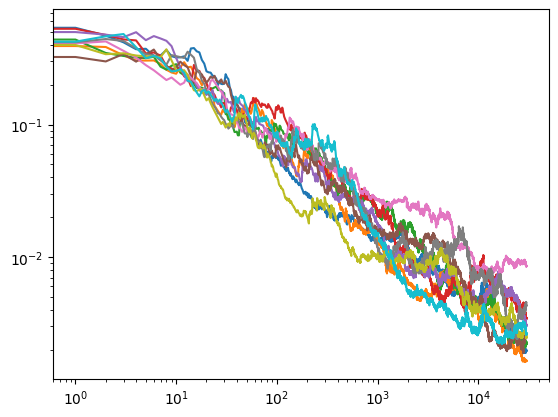

In [ ]:
# Load data from QST_settings.npy
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"
qst = QST.load_data(base_path)


# You can perform BME with the uncorrected POVM (default setting: Pauli-6)
qst.perform_BME()
uncorrected_infidelity = qst.get_infidelity()


# Perform BME with corrected POVM
use_corrected_POVM = True
qst.perform_BME(use_corrected_POVM)
corrected_infidelity = qst.get_infidelity()


for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()


Example of loading results directly from QST_results.npy

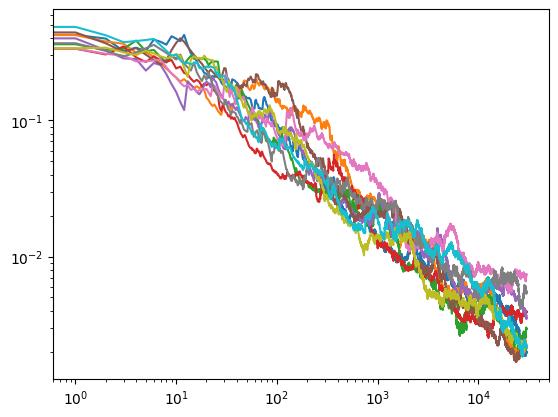

In [ ]:
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"

# The data is saved in the following order
with open(f'{base_path}/QST_results.npy','rb') as f:
    corrected_infidelity = np.load(f)
    uncorrected_infidelity = np.load(f)
    uncorrected_rho_est = np.load(f)
    corrected_rho_estm = np.load(f)
    
for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()
